# Chapter 1. Neural encoding I: Firing rates and spike statistics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.integrate import odeint
%matplotlib notebook
plt.style.use('seaborn-whitegrid')

## Task 1
Generate spikes for 10 s (or longer if you want better statistics) using
a Poisson spike generator with a constant rate of 100 Hz, and record
their times of occurrence. Compute the coefficient of variation of the
interspike intervals, and the Fano factor for spike counts obtained
over counting intervals ranging from 1 to 100 ms. Plot the interspike
interval histogram.

## Homogeneous Poisson processes and useful functions

In [23]:
def HomogeneousPoisson(rate, duration, dt=1e-6):
    '''
    Homogeneous Poisson process spike generator, 
    implemented by dividing time into bins and calculating
    prob. of spike generation.
    
    Return: array with spike times
    '''
    NoBins = int(duration/dt)
    time = np.random.uniform(0, 1, NoBins)
    
    # choose elements that have x_rand less than prob. of firing a spike
    spikes = np.nonzero(rate * dt > time)

    # normalize indices in order to be consistent with time
    spikes = (np.array(spikes) / NoBins) * duration
    
    return spikes.flatten()

def HomogeneousPoisson2(rate, duration):
    '''
    Homogeneous Poisson process spike generator,
    implemented by calculating interspike intervals.
    
    Return: array with spike times
    '''
    spikes = [0]
    
    while spikes[-1] < duration:
        spikes.append(spikes[-1] - np.log(np.random.rand()) / rate)
    return np.array(spikes[1:-1])


def distribution_spike_counts(spikes_times, step_interval=100, binwidth=1, plot=False):
    spikes_counts = spike_count(spikes_times, step_interval)
    if plot:
        plt.figure(dpi=100)
        plt.hist(spikes_counts, bins='auto', 
             color='purple', ec='black',  weights=np.ones(len(spikes_counts)) / len(spikes_counts))
        plt.xlabel('no. of spikes')
    else:
        return spikes_counts

def ISI_distribution(spikes):
    plt.figure(dpi=100)
    isi = np.diff(spikes) * 1000
    plt.hist(isi, bins='auto', color='purple', ec='black')
    plt.xlabel('ISI [ms]', fontsize=16)
    plt.ylabel('no. of intervals', fontsize=16)
    
def spike_count(data, step_interval=100):
    ''''''
    spikes_counts = []
    step_interval /= 1000 # converts to seconds
    start = 0
    end = step_interval
    while end <= np.max(data):
        spikes_counts.append( len(data[ (data > start) & (data <= end) ]) )
        start += step_interval
        end += step_interval
    return np.array(spikes_counts)

def fano(data):
    '''
    Computes Fano's factor for different intervals
    over which spikes are counted.
    duration/interval = no. of counts
    F = Var(data)/mean(data)
    '''
    fanos = []
    data = np.array(data)
    for t in range(1, 100): # ms
        spikes_counts = spike_count(data, step_interval=t)
        fanos.append( np.var(spikes_counts)/np.mean(spikes_counts) )
        
    return fanos

def coefficient_variation(data):
    '''
    Calculates coefficinet of variation
    C_V = std(data) / mean(data)
    '''
    return np.std(data) / np.mean(data)

Fixing the problem with Fano factors

In [3]:
spikes = HomogeneousPoisson2(100, 10)
print('Fano factors for spike counts over 10 s duration (with different intervals [0, 100] ms)')
print(fano(spikes)[0])

Fano factors for spike counts over 10 s duration (with different intervals [0, 100] ms)
1.0066270602729284


In [4]:
m = HomogeneousPoisson(100, 100)
m2 = HomogeneousPoisson2(100, 100)

#plt.vlines(m, 0, 1)
#plt.vlines(m2, 0, 1)
#plt.title('Spike Train', loc='left')

## ISI (interspike intervals) distribution (density)

<IPython.core.display.Javascript object>


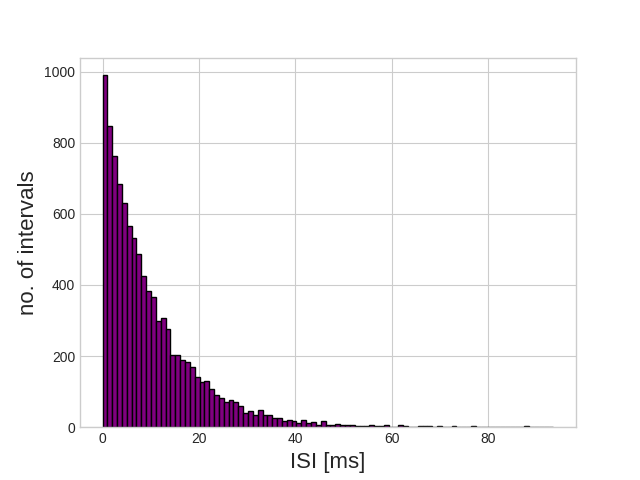

In [25]:
ISI_distribution( HomogeneousPoisson2(100, 100) )

As can be seen, distribution is exponentially decaying, which makes sense, because the longer it has been since
last spike the more likely it will be fired soon. 
Due to the absense of refractoriness, distribution has the peak at 0. But in real neurons there is refractoriness
after firing the spike and, thus, no spike can be fired immediately after this event.

## Spike counts distribution
Firing rate 100 Hz

<IPython.core.display.Javascript object>


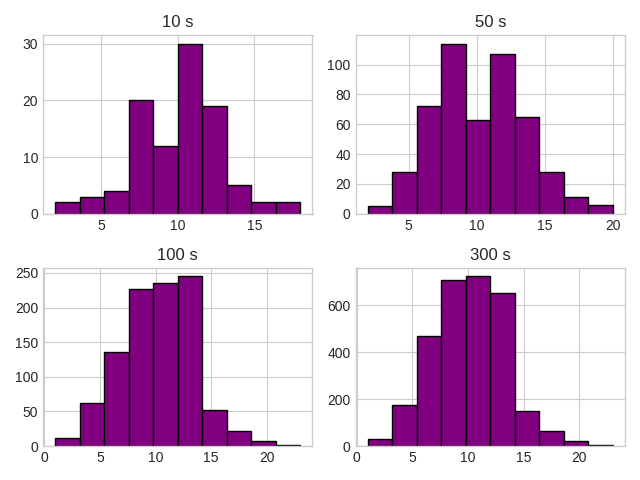

In [6]:
spikes = HomogeneousPoisson2(100, 600)
distribution_spike_counts(spikes)

fig, axs = plt.subplots(2, 2)
fig.dpi=100
axs[0, 0].hist( distribution_spike_counts(HomogeneousPoisson2(100, 10)), color='purple', ec='black')
axs[0, 0].set_title('10 s')
axs[0, 1].hist( distribution_spike_counts(HomogeneousPoisson2(100, 50)), color='purple', ec='black' )
axs[0, 1].set_title('50 s')
axs[1, 0].hist( distribution_spike_counts(HomogeneousPoisson2(100, 100)), color='purple', ec='black' )
axs[1, 0].set_title('100 s')
axs[1, 1].hist( distribution_spike_counts(HomogeneousPoisson2(100, 300)), color='purple', ec='black' )
axs[1, 1].set_title('300 s')
plt.tight_layout()

As can be seen, for larger simulation times, distribution of counter spikes approaches normal distribution

## Compute the coefficient of variation ($C_V$) of ISI

In [7]:
cv = coefficient_variation(isi)
print('Coefficient of variation: %s' % cv)

Coefficient of variation: 0.9991772999338576


## Compute the coefficient of variation ($C_V$) and fano factor for spike counts

In [8]:
cv = coefficient_variation(m)
print('Coefficient of variation: %s' % cv)

fano_factor = fano(m)
print('Fano factor: %s' % fano_factor[0])

Coefficient of variation: 0.5771292333541161
Fano factor: 1.0042937821593054


## Task 2

Add a refractory period to the Poisson spike generator by allowing
the firing rate to depend on time. Initially, set the firing rate to a
constant value, $r(t) = r_0 $. After every spike, set $r(t)$ to 0, and then
allow it to recover exponentially back to $r_0$ with a time constant $\tau_{ref}$
that controls the refractory recovery rate. In other words, have $r(t)$
obey the equation

$$
\tau_{ref} \frac{dr}{dt} = r_0 - r
$$

except immediately after a spike, when it is set to 0.
Plot the coefficient of variation as a function of $\tau_{ref}$ over
the range $1 \ ms\ \le \tau_{ref} \le 20 \ ms$, and plot interspike interval histograms for a few values of $\tau_{ref}$ in this range.
Compute the Fano factor for spike counts obtaines over counting
intervals ranging from 1 to 100 ms for the case $\tau_{ref}=10 \ ms$

If we solve the above equaition, we will get:
$$
r(t) = r_0 - (r_0 - r_{init})\cdot \exp{\left(-\frac{t}{\tau_{ref}}\right)}
$$

In [9]:
def HomogeneousPoissonRefractory(rate, duration, tau):
    '''
    Homogeneous Poisson process spike generator,
    implemented by calculating interspike intervals.
    
    Return: array with spike times
    '''
    spikes = [0]
    while spikes[-1] < duration:
        spikes.append(spikes[-1] - np.log(np.random.rand()) / rate)
        
    ToBeRemoved = []
    for i in range(1, len(spikes)):
        t = spikes[i]
        t_prev = spikes[i-1]
        
        # calculating how much rate has recovered after previous spike
        new_rate = rate_recovery(t - t_prev, r0=rate, tau_ref=tau)
        x_rand = random.random()
        if new_rate / rate < x_rand:
            ToBeRemoved.append(i)
            
    spikes = np.delete( np.array(spikes), ToBeRemoved )
    return spikes               
    


def rate_recovery(t, r0, tau_ref):
    tau_ref /= 1000 # converts to seconds

    '''
    Introduces exponential recovering of firing rate,
    after firing a spike
    Should be used with Inhomogeneous Poisson process
    '''
    return r0 * (1 - np.exp(-t/tau_ref) )

<IPython.core.display.Javascript object>


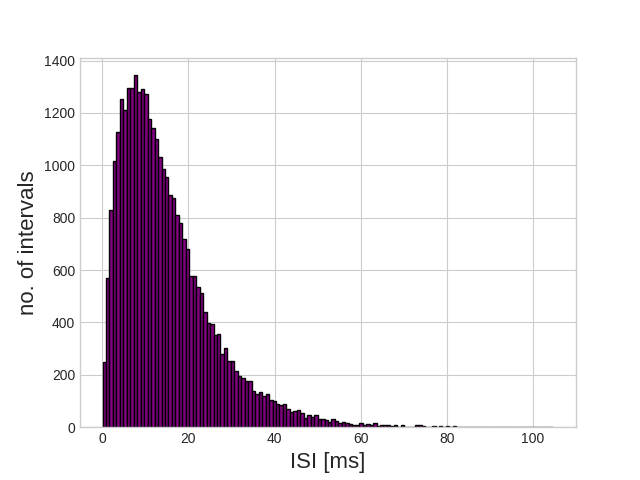

In [29]:
spikes_refrac = HomogeneousPoissonRefractory(100, 500, tau=5)
ISI_distribution(spikes_refrac)

<IPython.core.display.Javascript object>


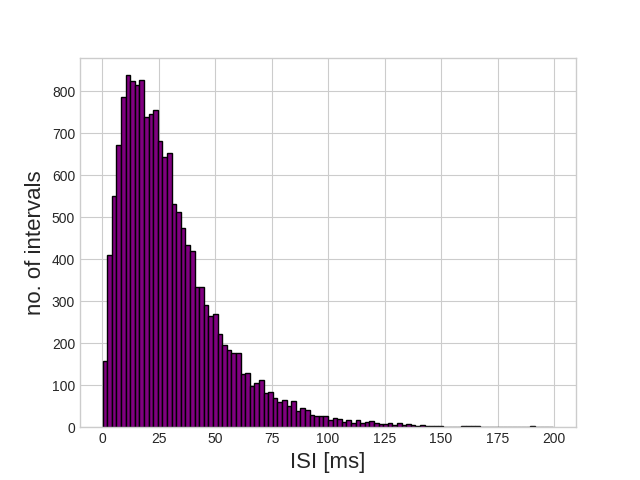

In [30]:
spikes_refrac = HomogeneousPoissonRefractory(100, 500, tau=20)
ISI_distribution(spikes_refrac)

<IPython.core.display.Javascript object>


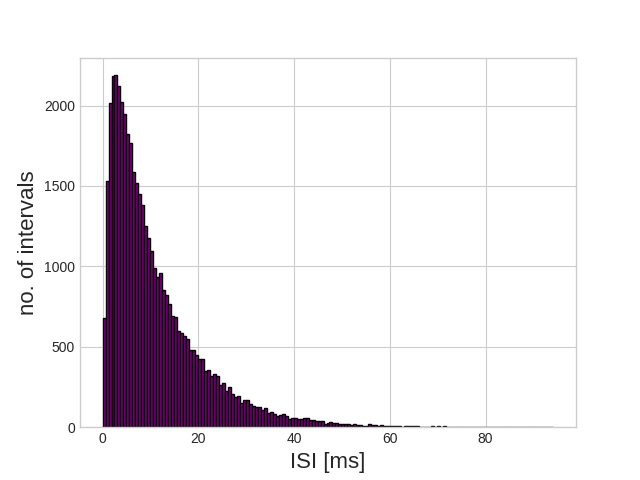

In [31]:
spikes_refrac = HomogeneousPoissonRefractory(100, 500, tau=1)
ISI_distribution(spikes_refrac)

Plottting coefficient of variation ($C_V$) of ISI as a fucntion of $\tau_{ref}$

In [11]:
coeffs = []
for i in range(1, 21):
    spikes = HomogeneousPoissonRefractory(100, 500, tau=i)
    isi = np.diff(spikes)
    coeffs.append(coefficient_variation(isi))

<IPython.core.display.Javascript object>


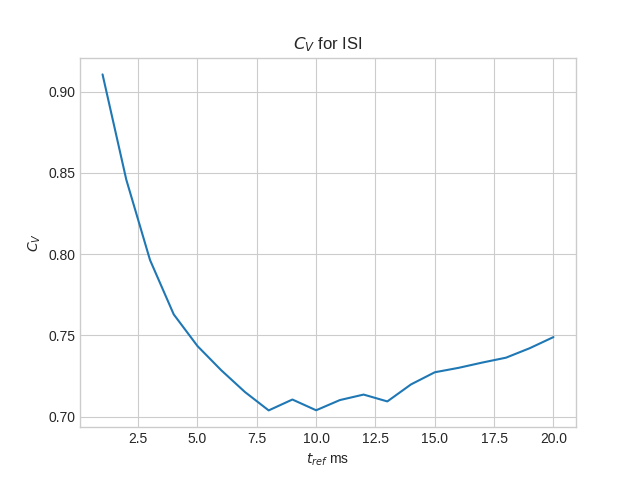

In [12]:
plt.figure()
plt.plot([i for i in range(1, 21)], coeffs)
plt.xlabel('$t_{ref}$ ms')
plt.ylabel('$C_V$')
plt.title('$C_V$ for ISI')
plt.show()

Plottting coefficient of variation ($C_V$) of spike_counts as a fucntion of $\tau_{ref}$

In [13]:
coeffs = []
for i in range(1, 21):
    spikes = HomogeneousPoissonRefractory(100, 500, tau=i)
    coeffs.append(coefficient_variation(spike_count(spikes, step_interval=100)))

<IPython.core.display.Javascript object>


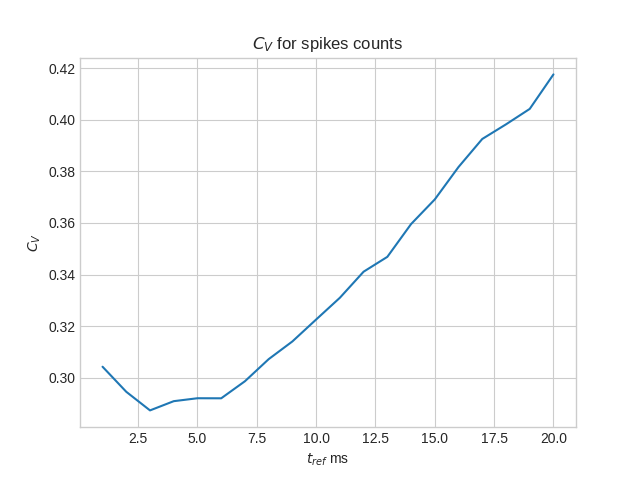

In [14]:
plt.figure()
plt.plot([i for i in range(1, 21)], coeffs)
plt.xlabel('$t_{ref}$ ms')
plt.ylabel('$C_V$')
plt.title('$C_V$ for spikes counts')
plt.show()

Computing Fano factors for spikes counts with step intervals [1, 100] ms

In [15]:
print( fano(HomogeneousPoissonRefractory(100, 10, tau=10)) )

[0.957576858274004, 0.9111832818376556, 0.888542039965289, 0.8500491692567744, 0.8155819669703761, 0.7769936778237967, 0.7584835524724839, 0.7633039121948906, 0.7367776454485663, 0.7024510626536232, 0.722891828150982, 0.6803580956898085, 0.7133233167674745, 0.7105343215885833, 0.6440119760479042, 0.613092715022301, 0.6549588857190803, 0.6240503404020833, 0.6397655325304827, 0.6454813145985256, 0.6264483052078794, 0.6346643455554345, 0.637782723226451, 0.569166844742028, 0.6000543196464284, 0.6348463417770348, 0.5655466894398334, 0.6190884451573648, 0.6015784187114362, 0.5375289025908578, 0.5731661711062748, 0.5469775092525229, 0.553135313531353, 0.591105890250042, 0.560998407533061, 0.5062255146377946, 0.6058382960067223, 0.59271919587396, 0.5835343067380667, 0.5641584158415841, 0.5897338094465183, 0.5217156169398453, 0.5435091148599839, 0.5694182225019231, 0.5273487773487773, 0.46962485239349616, 0.6013852089434297, 0.5213675213675213, 0.5086682197631527, 0.5383663366336634, 0.5185188